In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

data = pd.read_json('data/data.json')

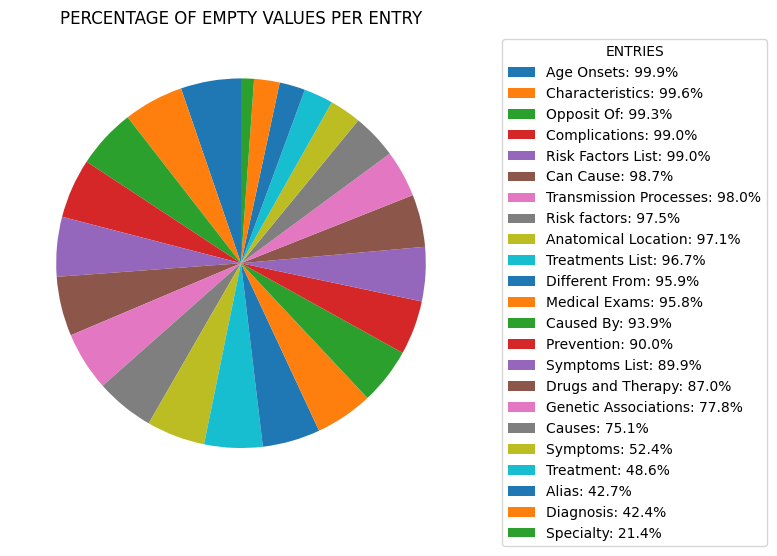

In [41]:
missing_percentages_per_entry = data.isnull().mean(axis=1) * 100
missing_percentages_per_entry = missing_percentages_per_entry[missing_percentages_per_entry > 0]

if missing_percentages_per_entry.empty:
    print("There is no empty spaces")
else:
    missing_percentages_per_entry = missing_percentages_per_entry.sort_values(ascending=False)
    plt.figure(figsize=(6, 6))
    wedges, texts = plt.pie(missing_percentages_per_entry, startangle=90)
    plt.title("PERCENTAGE OF EMPTY VALUES PER ENTRY")
    legend_labels = [f'{index}: {value:.1f}%' for index, value in zip(missing_percentages_per_entry.index, missing_percentages_per_entry)]
    plt.legend(legend_labels, title="ENTRIES", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.show()

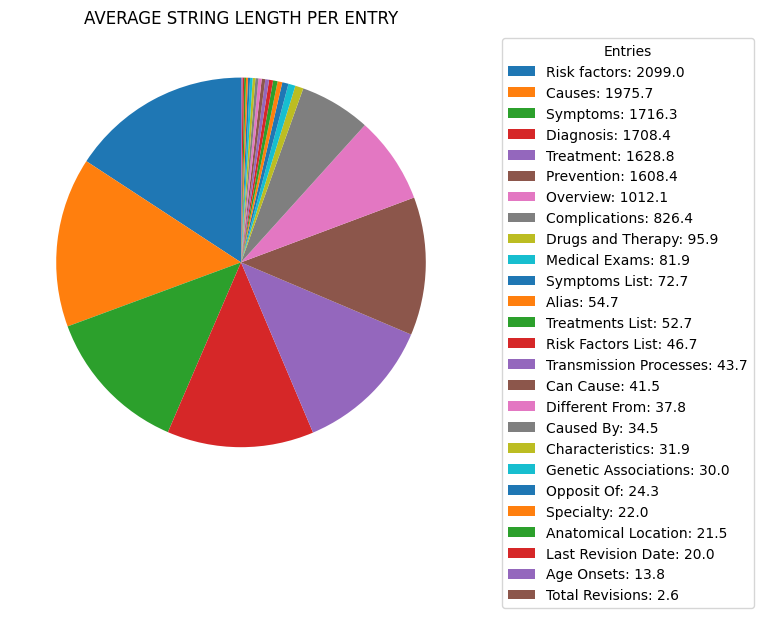

In [42]:
def mean_string_length(entry):
    strings = entry.dropna().astype(str)
    string_lengths = strings.apply(len)
    return string_lengths.mean()

mean_lengths_per_entry = data.apply(mean_string_length, axis=1)
mean_lengths_per_entry = mean_lengths_per_entry[mean_lengths_per_entry.notna()]

if mean_lengths_per_entry.empty:
    print("There are no valid string lengths in any entry.")
else:
    mean_lengths_per_entry = mean_lengths_per_entry.sort_values(ascending=False)
    plt.figure(figsize=(6, 6))
    wedges, texts = plt.pie(mean_lengths_per_entry, startangle=90)
    plt.title("AVERAGE STRING LENGTH PER ENTRY")
    legend_labels = [f'{index}: {value:.1f}' for index, value in zip(mean_lengths_per_entry.index, mean_lengths_per_entry)]
    plt.legend(legend_labels, title="Entries", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.show()


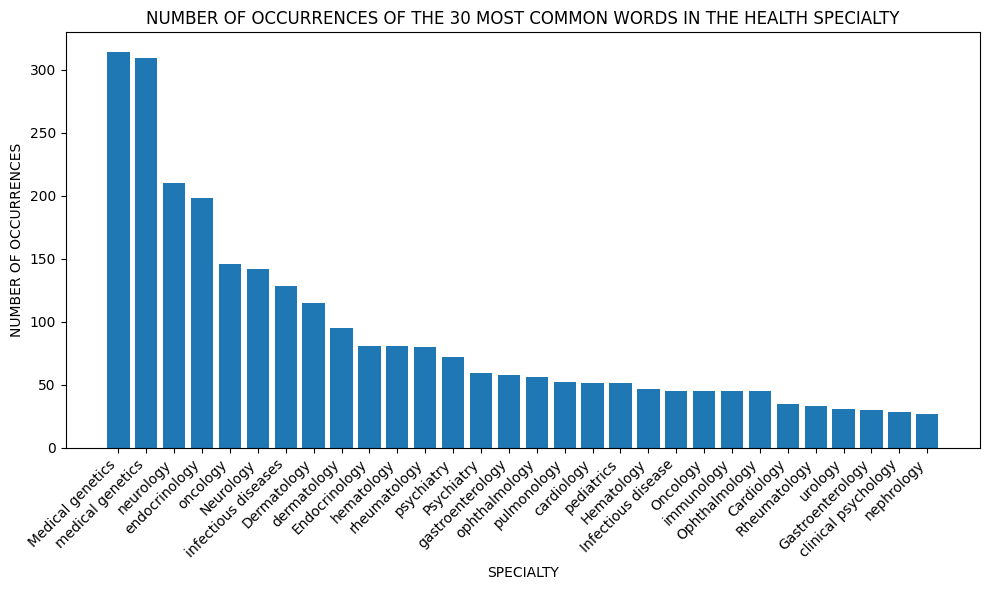

In [43]:
if "Specialty" in data.index:
    all_words = []
    for col in data.columns:
        words = data.at["Specialty", col]
        if isinstance(words, list):
            all_words.extend(words)

    word_counts = Counter(all_words)
    most_common_words = word_counts.most_common(30)

    # for word, count in most_common_words:
    #     print(f'{word}: {count} vezes')

    plt.figure(figsize=(10, 6))
    words, counts = zip(*most_common_words)
    plt.bar(words, counts)
    plt.xticks(rotation=45, ha="right")
    plt.title("NUMBER OF OCCURRENCES OF THE 30 MOST COMMON WORDS IN THE HEALTH SPECIALTY")
    plt.xlabel("SPECIALTY")
    plt.ylabel("NUMBER OF OCCURRENCES")
    plt.tight_layout()
    plt.show()


Through this graph it is possible to see that there are a large number of diseases whose Wikipedia page has already had several changes. With this information, we can predict that these diseases with the most reviews will be the most common, and the most frequently researched.

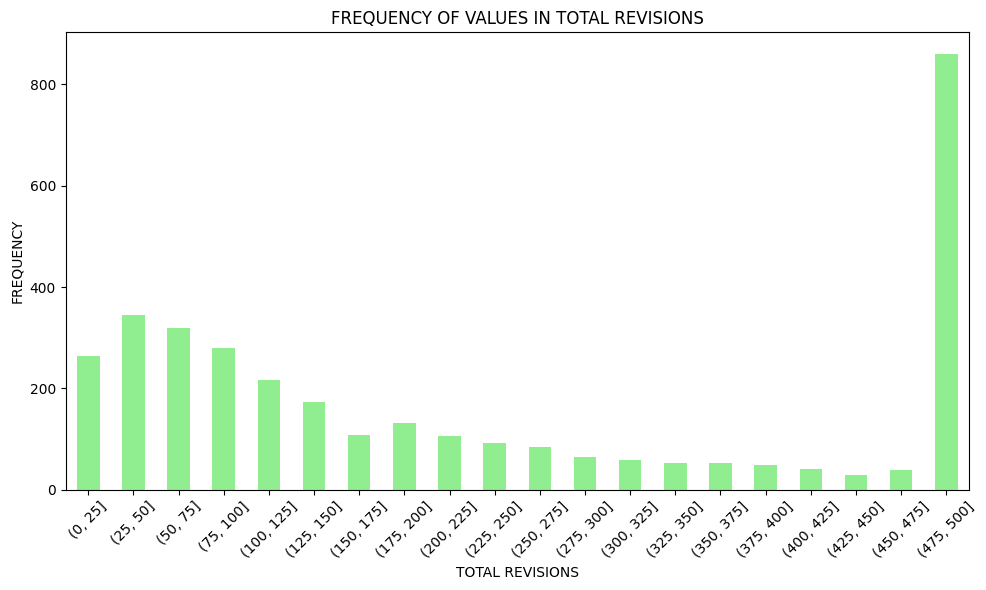

In [49]:

if "Total Revisions" in data.index:

    total_revisions = data.loc["Total Revisions"]
    bins = range(0, int(total_revisions.max()) + 25, 25)
    binned_revisions = pd.cut(total_revisions, bins=bins)
    value_counts = binned_revisions.value_counts().sort_index()

    plt.figure(figsize=(10, 6))
    value_counts.plot(kind='bar', color='lightgreen')
    plt.title("FREQUENCY OF VALUES IN TOTAL REVISIONS")
    plt.xlabel("TOTAL REVISIONS")
    plt.ylabel("FREQUENCY")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()